# 意思決定分析と予測の活用｜第3部 決定分析の活用
https://logics-of-blue.com/decision-analysis-and-forecast-book-support/

## 第2章 コスト/ロスモデルと予測の価値

### Pythonによる分析の準備

#### ライブラリの読み込みなど

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)
# 本文の数値とあわせるために、小数点以下3桁で丸める
pd.set_option('display.precision', 3)

# グラフ描画
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

#### 評価対象となる予測

In [2]:
joint_forecast_state = pd.DataFrame({
    '予測-問題なし': [0.35, 0.1],
    '予測-問題あり': [0.05, 0.5]
})
joint_forecast_state.index = ['問題なし', '問題あり']
print(joint_forecast_state)

          予測-問題なし  予測-問題あり
問題なし           0.35           0.05
問題あり           0.10           0.50


In [3]:
# 予測の周辺分布
marginal_forecast = joint_forecast_state.sum(axis=0)
marginal_forecast

予測-問題なし    0.45
予測-問題あり    0.55
dtype: float64

In [4]:
# 自然の状態の周辺分布
marginal_state = joint_forecast_state.sum(axis=1)
marginal_state

問題なし    0.4
問題あり    0.6
dtype: float64

In [5]:
# 予測が得られた後の条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis=1)
print(conditional_forecast)

          予測-問題なし  予測-問題あり
問題なし          0.778          0.091
問題あり          0.222          0.909


### CL比とユーザーの最適戦略の関係

In [6]:
# コストロス比は0から1の範囲を取る
cl_ratio_array = np.arange(0.01, 1, 0.01)

# スケーリングされた期待利得を求める
# 常に対策なし
esv_naive_1 = -1 * np.repeat(marginal_state['問題あり'], len(cl_ratio_array))
# 常に対策あり
esv_naive_2 = -1 * cl_ratio_array
# 予測に忠実に従う
esv_f = -1 * joint_forecast_state.loc['問題あり', '予測-問題なし'] \
        - cl_ratio_array * marginal_forecast['予測-問題あり']

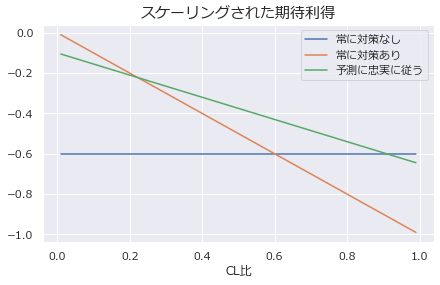

In [7]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(cl_ratio_array, esv_naive_1, label='常に対策なし')
ax.plot(cl_ratio_array, esv_naive_2, label='常に対策あり')
ax.plot(cl_ratio_array, esv_f, label='予測に忠実に従う')

# グラフの装飾
ax.set_title('スケーリングされた期待利得', fontsize=15)  # タイトル
ax.set_xlabel('CL比')                                    # X軸ラベル
ax.legend(loc='upper right')                             # 凡例

In [8]:
# 予測が価値を生み出す範囲
lower = conditional_forecast.loc['問題あり', '予測-問題なし']
upper = conditional_forecast.loc['問題あり', '予測-問題あり']

print(f'予測が価値を生み出すCL比の範囲: {lower:.3g}～{upper:.3g}')

予測が価値を生み出すCL比の範囲: 0.222～0.909


### CL比で表現する予測の価値

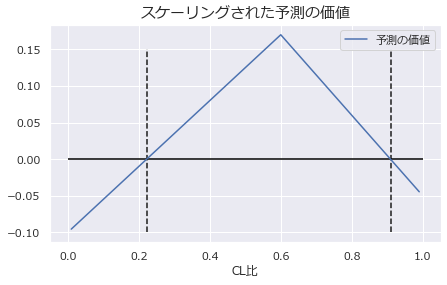

In [9]:
# 無技術最良予測に従うときの期待利得
esv_naive = np.maximum(esv_naive_1, esv_naive_2)

# 予測の価値
value_f = esv_f - esv_naive

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(cl_ratio_array, value_f, label='予測の価値')

# 予測の価値が正である範囲
ax.vlines(x=lower, ymin=-0.1, ymax=0.15, linestyle='--')
ax.vlines(x=upper, ymin=-0.1, ymax=0.15, linestyle='--')

# グラフの装飾
ax.hlines(y=0, xmin=0, xmax=1, color='black')              # 高さ0の基準線
ax.set_title('スケーリングされた予測の価値', fontsize=15)  # タイトル
ax.set_xlabel('CL比')                                      # X軸ラベル
ax.legend(loc='upper right')                               # 凡例

In [10]:
# スケーリングされた予測の価値を計算する関数
# 同時分布は以下の形式になっている必要がある
# 1列目「予測-問題なし」・2列目「予測-問題あり」
# 1行目「問題なし」・2行目「問題あり」
def forecast_value(cl_ratio, joint_prob):
    # 周辺分布
    marginal_forecast = joint_prob.sum(axis=0)
    marginal_state = joint_prob.sum(axis=1)
    
    # ESVの計算
    # 常に対策なし
    esv_naive_1 = -1 * marginal_state[1]
    # 常に対策あり
    esv_naive_2 = -1 * cl_ratio
    # 予測に忠実に従う
    esv_f = -1 * joint_prob.iloc[1, 0] - cl_ratio * marginal_forecast[1]
    
    # 予測の価値の計算
    # 無技術最良予測
    esv_naive = np.maximum(esv_naive_1, esv_naive_2)
    # 予測の価値
    value_f = esv_f - esv_naive
    return(value_f)

In [11]:
# 関数を使うと、以下のようにして、CL比を変化させたときの予測の価値を計算できる
value_f_func = np.apply_along_axis(func1d=forecast_value, 
                                   axis=0, 
                                   arr=cl_ratio_array, 
                                   joint_prob=joint_forecast_state)

In [12]:
# 正しく計算されていることの確認
all(value_f == value_f_func)

True

In [13]:
value_04 = forecast_value(0.4, joint_forecast_state)
print(f'CL比が0.4のユーザーの予測の価値: {value_04:.3g}')

CL比が0.4のユーザーの予測の価値: 0.08


In [14]:
print(f'CL比が0.4、Lが1000万のユーザーの予測の価値: {value_04*1000:.3g}万')

CL比が0.4、Lが1000万のユーザーの予測の価値: 80万


### 予測の的中率と予測の価値の関係

In [15]:
# 予測が価値を生み出すために必要な的中率を求める関数
def required_accuracy(cl_ratio, p_theta):
    ret = np.where(cl_ratio >= p_theta,              # 条件
                   1 - 2 * p_theta * (1 - cl_ratio), # 条件を満たすとき
                   1 - 2 * cl_ratio * (1 - p_theta)) # 満たさないとき
    return(ret)

In [16]:
# CL比=0.2の予測ユーザーに対して、「問題あり」確率=0.8のとき
# 予測が価値を生み出すのに最低限必要な的中率
required_accuracy(cl_ratio=0.2, p_theta=0.8)

array(0.92)

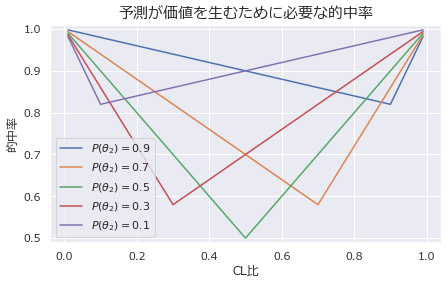

In [17]:
# CL比
cl_ratio_array = np.arange(0.01, 1, 0.01)

# 予測が価値を生み出すために必要な的中率
req_acc09 = np.apply_along_axis(required_accuracy, 0, cl_ratio_array, 0.9)
req_acc07 = np.apply_along_axis(required_accuracy, 0, cl_ratio_array, 0.7)
req_acc05 = np.apply_along_axis(required_accuracy, 0, cl_ratio_array, 0.5)
req_acc03 = np.apply_along_axis(required_accuracy, 0, cl_ratio_array, 0.3)
req_acc01 = np.apply_along_axis(required_accuracy, 0, cl_ratio_array, 0.1)

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(cl_ratio_array, req_acc09, label=r'$P(\theta_2)=0.9$')
ax.plot(cl_ratio_array, req_acc07, label=r'$P(\theta_2)=0.7$')
ax.plot(cl_ratio_array, req_acc05, label=r'$P(\theta_2)=0.5$')
ax.plot(cl_ratio_array, req_acc03, label=r'$P(\theta_2)=0.3$')
ax.plot(cl_ratio_array, req_acc01, label=r'$P(\theta_2)=0.1$')

# グラフの装飾
ax.set_title('予測が価値を生むために必要な的中率', fontsize=15)  # タイトル
ax.set_ylim(0.49, 1.01)                                          # Y軸の範囲
ax.set_xlabel('CL比')                                            # X軸ラベル
ax.set_ylabel('的中率')                                          # Y軸ラベル
ax.legend()                                                      # 凡例

### 個別ユーザーのための予測の最適化

In [18]:
# 的中率を求める関数
def accuracy(joint_prob):
    return(joint_prob.iloc[0, 0] + joint_prob.iloc[1, 1])

In [19]:
# バイアスのない予測
zero_bias = pd.DataFrame({
    '予測-問題なし': [0.4, 0.1],
    '予測-問題あり': [0.1, 0.4]
})
zero_bias.index = ['問題なし', '問題あり']
print('的中率：', accuracy(zero_bias))
print(zero_bias)

的中率： 0.8
          予測-問題なし  予測-問題あり
問題なし            0.4            0.1
問題あり            0.1            0.4


In [20]:
# 見逃し(偽陰性：False Negative)を減らした予測
decrease_fn = pd.DataFrame({
    '予測-問題なし': [0.3, 0.05],
    '予測-問題あり': [0.2, 0.45]
})
decrease_fn.index = ['問題なし', '問題あり']
print('的中率：', accuracy(decrease_fn))
print(decrease_fn)

的中率： 0.75
          予測-問題なし  予測-問題あり
問題なし           0.30           0.20
問題あり           0.05           0.45


In [21]:
# 空振り(偽陽性：False Positive)を減らした予測
decrease_fp = pd.DataFrame({
    '予測-問題なし': [0.45, 0.2],
    '予測-問題あり': [0.05, 0.3]
})
decrease_fp.index = ['問題なし', '問題あり']
print('的中率：', accuracy(decrease_fp))
print(decrease_fp)

的中率： 0.75
          予測-問題なし  予測-問題あり
問題なし           0.45           0.05
問題あり           0.20           0.30


In [22]:
# CL比が0.5の予測ユーザーにとっての予測の価値
print(f'バイアスなし予測の価値: {forecast_value(0.5, zero_bias):.3g}')
print(f'見逃し減少予測の価値　: {forecast_value(0.5, decrease_fn):.3g}')
print(f'空振り減少予測の価値　: {forecast_value(0.5, decrease_fp):.3g}')

バイアスなし予測の価値: 0.15
見逃し減少予測の価値　: 0.125
空振り減少予測の価値　: 0.125


In [23]:
# CL比が0.3の予測ユーザーにとっての予測の価値
print(f'バイアスなし予測の価値: {forecast_value(0.3, zero_bias):.3g}')
print(f'見逃し減少予測の価値　: {forecast_value(0.3, decrease_fn):.3g}')
print(f'空振り減少予測の価値　: {forecast_value(0.3, decrease_fp):.3g}')

バイアスなし予測の価値: 0.05
見逃し減少予測の価値　: 0.055
空振り減少予測の価値　: -0.005


In [24]:
# CL比が0.7の予測ユーザーにとっての予測の価値
print(f'バイアスなし予測の価値: {forecast_value(0.7, zero_bias):.3g}')
print(f'見逃し減少予測の価値　: {forecast_value(0.7, decrease_fn):.3g}')
print(f'空振り減少予測の価値　: {forecast_value(0.7, decrease_fp):.3g}')

バイアスなし予測の価値: 0.05
見逃し減少予測の価値　: -0.005
空振り減少予測の価値　: 0.055


### 完全的中予測の価値

In [25]:
# Lで標準化された完全的中予測の価値を計算する関数
def perfect_forecast_value(cl_ratio, marginal_state):
    # ESVの計算
    # 常に対策なし
    esv_naive_1 = -1 * marginal_state[1]
    # 常に対策あり
    esv_naive_2 = -1 * cl_ratio
    # 完全的中予測に従う
    esv_perfect = -1 * cl_ratio * marginal_state[1]
    
    # 予測の価値の計算
    # 無技術最良予測
    esv_naive = np.maximum(esv_naive_1, esv_naive_2)
    # 予測の価値
    value_p = esv_perfect - esv_naive
    return(value_p)

In [26]:
value_p = perfect_forecast_value(0.4, marginal_state)
print(f'CL比が0.4のユーザーの完全的中予測の価値: {value_p:.3g}')

CL比が0.4のユーザーの完全的中予測の価値: 0.16


### 予測の有効性

In [27]:
# 予測の価値と、完全的中予測の価値
value_p = perfect_forecast_value(0.4, marginal_state)
value_f = forecast_value(0.4, joint_forecast_state)

# 予測の有効性
efficiency = value_f / value_p
print(f'予測の有効性: {efficiency:.3g}')

予測の有効性: 0.5


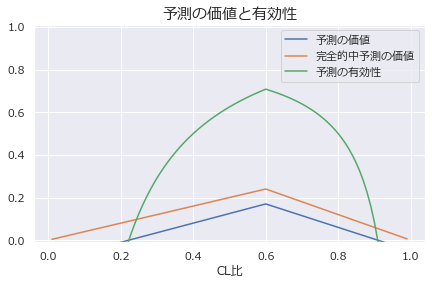

In [28]:
# CL比
cl_ratio_array = np.arange(0.01, 1, 0.01)

# 予測の価値
value_f = np.apply_along_axis(forecast_value, 0, 
                              cl_ratio_array, joint_forecast_state)

# 完全的中予測の価値
value_p = np.apply_along_axis(perfect_forecast_value, 0, 
                              cl_ratio_array, marginal_state)

# 完全的中予測の価値で標準化された予測の価値
efficiency = value_f / value_p

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(cl_ratio_array, value_f, label='予測の価値')
ax.plot(cl_ratio_array, value_p, label='完全的中予測の価値')
ax.plot(cl_ratio_array, efficiency, label='予測の有効性')

# グラフの装飾
ax.set_title('予測の価値と有効性', fontsize=15)  # タイトル
ax.set_ylim(-0.01, 1.01)                         # Y軸の範囲
ax.set_xlabel('CL比')                            # X軸ラベル
ax.legend()                                      # 凡例

### Claytonのスキルスコア

In [29]:
# 予測が価値を生み出す範囲
lower = conditional_forecast.loc['問題あり', '予測-問題なし']
upper = conditional_forecast.loc['問題あり', '予測-問題あり']

clayton = upper - lower
print(f'Claytonのスキルスコア: {clayton:.3g}')

Claytonのスキルスコア: 0.687


### Peirceのスキルスコア

In [30]:
# efficiencyの最大値として Peirceのスキルスコアを求める
print(f'Peirceのスキルスコア: {max(efficiency):.3g}')

Peirceのスキルスコア: 0.708


In [31]:
# 自然の状態が得られた後の条件付き分布
conditional_state = joint_forecast_state.div(marginal_state, axis=0)
print(conditional_state)

          予測-問題なし  予測-問題あり
問題なし          0.875          0.125
問題あり          0.167          0.833


In [32]:
# 条件付き分布からPeirceのスキルスコアを求める
peirce = conditional_state.loc['問題あり', '予測-問題あり'] \
       - conditional_state.loc['問題なし', '予測-問題あり']
print(f'Peirceのスキルスコア: {peirce:.3g}')

Peirceのスキルスコア: 0.708
